In this analysis, we aim to test **predicting one company's stock price based on another comapny's stock price.** Again the approach allows us to explore whether Meta's stock performance can serve as a reliable predictor for Google's stock prices. It's about testing the PyCaret's ability to identify the best regression model for this scenario.

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from pycaret.regression import setup, compare_models, predict_model


In [2]:
# Load Google and Meta stock data
google_data = pd.read_csv("../GOOGL_stock_data.csv", parse_dates=["Date"])
meta_data = pd.read_csv("../META_stock_data.csv", parse_dates=["Date"])



In [4]:
# Create lag features and moving averages for Google
google_data["Lag_1_google"] = google_data["Close"].shift(1)
google_data["Lag_2_google"] = google_data["Close"].shift(2)
google_data["50_MA_google"] = google_data["Close"].rolling(window=50).mean()
google_data["200_MA_google"] = google_data["Close"].rolling(window=200).mean()

# Create lag features and moving averages for Meta
meta_data["Lag_1_meta"] = meta_data["Close"].shift(1)
meta_data["Lag_2_meta"] = meta_data["Close"].shift(2)
meta_data["50_MA_meta"] = meta_data["Close"].rolling(window=50).mean()
meta_data["200_MA_meta"] = meta_data["Close"].rolling(window=200).mean()

In [5]:
# Drop missing values in both datasets
google_data.dropna(inplace=True)
meta_data.dropna(inplace=True)

# Merge Google and Meta datasets on Date
combined_data = pd.merge(google_data, meta_data, on="Date", suffixes=("_google", "_meta"))


In [6]:
# Create lag features and moving averages for Google stock data
combined_data["Lag_1_google"] = combined_data["Close_google"].shift(1)
combined_data["Lag_2_google"] = combined_data["Close_google"].shift(2)
combined_data["50_MA_google"] = combined_data["Close_google"].rolling(window=50).mean()
combined_data["200_MA_google"] = combined_data["Close_google"].rolling(window=200).mean()

# Drop rows with missing values (caused by lagging or rolling)
combined_data.dropna(inplace=True)

# Preview the data
print(combined_data.head())


          Date  Open_google  High_google  Low_google  Close_google  \
199 2013-12-18    26.823072    27.150902   26.502502     27.145897   
200 2013-12-19    27.046295    27.327078   27.004004     27.182684   
201 2013-12-20    27.234735    27.556807   27.227226     27.543043   
202 2013-12-23    27.723724    27.922922   27.655657     27.905405   
203 2013-12-24    27.902151    27.908909   27.730230     27.823824   

     Adj Close_google  Volume_google  Lag_1_google  Lag_2_google  \
199         27.078846       88323588     26.773273     26.851351   
200         27.115541       66561372     27.145897     26.773273   
201         27.475012      130333536     27.182684     27.145897   
202         27.836477       68795136     27.543043     27.182684   
203         27.755098       29338632     27.905405     27.543043   

     50_MA_google  ...  Open_meta  High_meta   Low_meta  Close_meta  \
199     25.453348  ...  54.860001  55.889999  53.750000   55.570000   
200     25.568644  ...  54.3

In [8]:
# Define features (X) and target (y)
X = combined_data[["Lag_1_google", "Lag_2_google", "50_MA_google", "200_MA_google"]]
y = combined_data["Close_meta"]

In [9]:
# Perform time-series-aware splitting (train-test split)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Combine training data into a single DataFrame for PyCaret
train_data = pd.concat([X_train, y_train], axis=1)
train_data.columns = ["Lag_1_google", "Lag_2_google", "50_MA_google", "200_MA_google", "Close_meta"]


In [10]:
regression_setup = setup(
    data=train_data,
    target="Close_meta",
    numeric_features=["Lag_1_google", "Lag_2_google", "50_MA_google", "200_MA_google"],
    session_id=123,
    fold_strategy="timeseries",
    data_split_shuffle=False,  # Ensure no shuffling
    fold_shuffle=False
)

,Description,Value
0,Session id,123
1,Target,Close_meta
2,Target type,Regression
3,Original data shape,"(2188, 5)"
4,Transformed data shape,"(2188, 5)"
5,Transformed train set shape,"(1531, 5)"
6,Transformed test set shape,"(657, 5)"
7,Numeric features,4
8,Preprocess,True
9,Imputation type,simple


In [11]:
# Compare models and select the best one
best_model = compare_models()


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lar,Least Angle Regression,12.9993,334.4392,15.2984,-2.6893,0.1116,0.0976,0.0030
br,Bayesian Ridge,12.9794,333.8993,15.2844,-2.6920,0.1115,0.0975,0.0040
lr,Linear Regression,13.0054,334.9038,15.3112,-2.6945,0.1117,0.0976,0.1970
ridge,Ridge Regression,13.0023,334.8217,15.3075,-2.6947,0.1117,0.0976,0.1800
en,Elastic Net,12.0762,306.4003,14.2830,-2.7212,0.1058,0.0920,0.1410
lasso,Lasso Regression,12.2273,313.4428,14.4964,-2.7409,0.1068,0.0929,0.1590
llar,Lasso Least Angle Regression,12.2300,313.5120,14.4987,-2.7412,0.1068,0.0929,0.0050
huber,Huber Regressor,14.2317,413.0983,16.5289,-2.9161,0.1172,0.1046,0.0050
lightgbm,Light Gradient Boosting Machine,12.9815,261.7121,14.9968,-2.9263,0.1147,0.0954,0.1410
rf,Random Forest Regressor,12.9686,266.7588,15.1849,-3.0771,0.1173,0.0960,0.0250


We can already see, that the results there are really bad. Relying solely on another company's stock prices to predict Google's stock prices is not effective with traditional regression models. There is a correlation, but it's not strong enough to translate into an actionable predictive relationship for stock prices.

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Least Angle Regression,112.2612,15885.6367,126.0382,0.2785,0.4899,0.5481


RMSE: 126.03823525684857
MAPE: 0.548052737862092


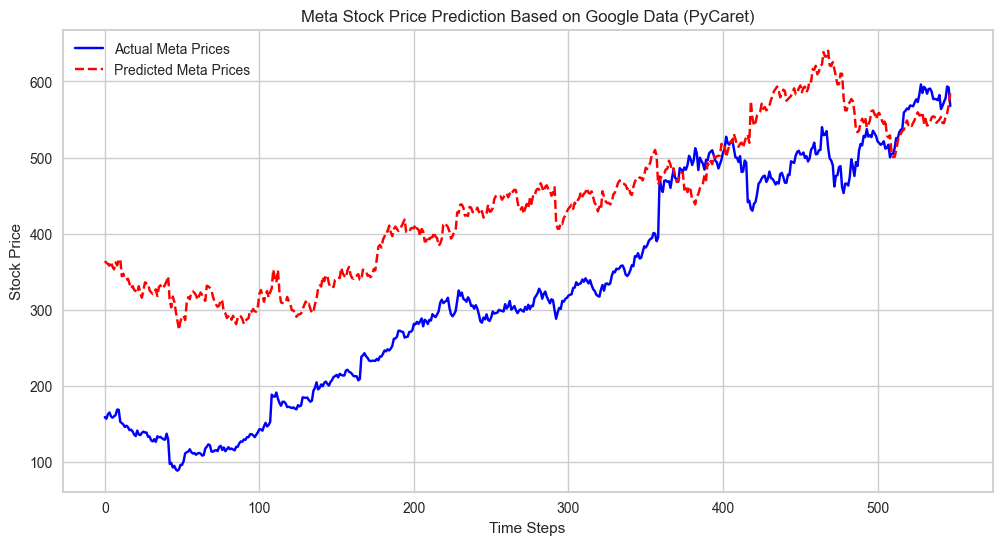

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
# Predict on the test set
test_data = X_test.copy()
test_data["Close_meta"] = y_test
predictions = predict_model(best_model, data=test_data)

# Add predictions to test data
test_data["Predicted"] = predictions["prediction_label"]

# Calculate evaluation metrics
rmse = mean_squared_error(test_data["Close_meta"], test_data["Predicted"], squared=False)
mape = mean_absolute_percentage_error(test_data["Close_meta"], test_data["Predicted"])

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(test_data["Close_meta"].values, label="Actual Meta Prices", color="blue")
plt.plot(test_data["Predicted"].values, label="Predicted Meta Prices", color="red", linestyle="--")
plt.title("Meta Stock Price Prediction Based on Google Data (PyCaret)")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

So, the actual meta prices and the predicted prices differ significantly (which is reflected in the high RMSE and MAPE). So the model struggles to match the true stock prices. But despite the large error margins, the **general trend** of the predictions somewhat aligns with the actual trend in some regions. So the model's ability to predict is inadequate, it has the capacity to follow overall trends.